# Stock Price Prediction Pipeline (with Sentiment & Macro)
End-to-end workflow demonstrating:
- Data loading
- Sentiment and macro feature engineering
- Exploratory visualizations
- Modeling and evaluation
- Simulated backtest and conclusions


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (14,6)
DATA_DIR = "../data/"


In [5]:
df = pd.read_csv(DATA_DIR + "features.csv", parse_dates=['date'])
print(df.head())
print(df.dtypes)


        date ticker  close_price  sentiment_score  usd_inr_rate  \
0 2019-01-01    TCS    1717.5715           0.0000         70.76   
1 2019-01-02    TCS    1736.0759           0.3818         70.76   
2 2019-01-03    TCS    1714.9988          -0.6486         70.76   
3 2019-01-03    TCS    1714.9988           0.0000         70.76   
4 2019-01-03    TCS    1714.9988          -0.3400         70.76   

   interest_rate  unemployment_rate  return_1  return_direction  
0           6.25               6.51       NaN                 1  
1           6.25               6.51  0.010774                 0  
2           6.25               6.51 -0.012141                 0  
3           6.25               6.51  0.000000                 0  
4           6.25               6.51  0.000000                 0  
date                 datetime64[ns]
ticker                       object
close_price                 float64
sentiment_score             float64
usd_inr_rate                float64
interest_rate        

Missing values:
 date                 0
ticker               0
close_price          0
sentiment_score      0
usd_inr_rate         0
interest_rate        0
unemployment_rate    0
return_1             6
return_direction     0
dtype: int64


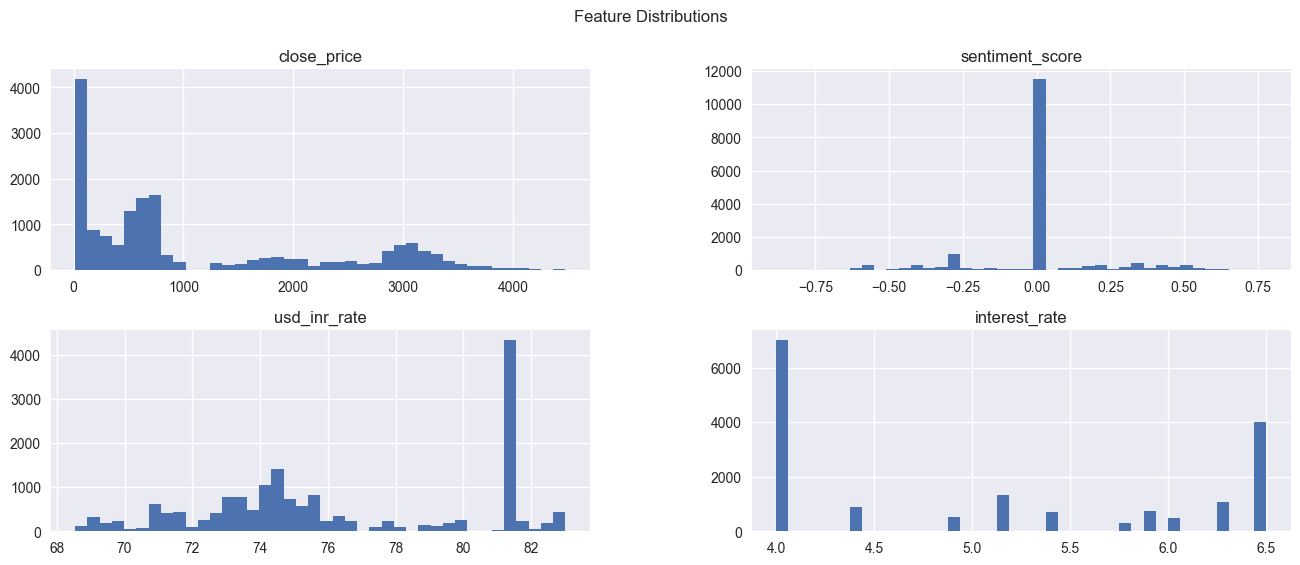

In [6]:
print("Missing values:\n", df.isna().sum())
df[['close_price', 'sentiment_score', 'usd_inr_rate', 'interest_rate']].hist(bins=40, figsize=(16,6))
plt.suptitle('Feature Distributions')
plt.show()


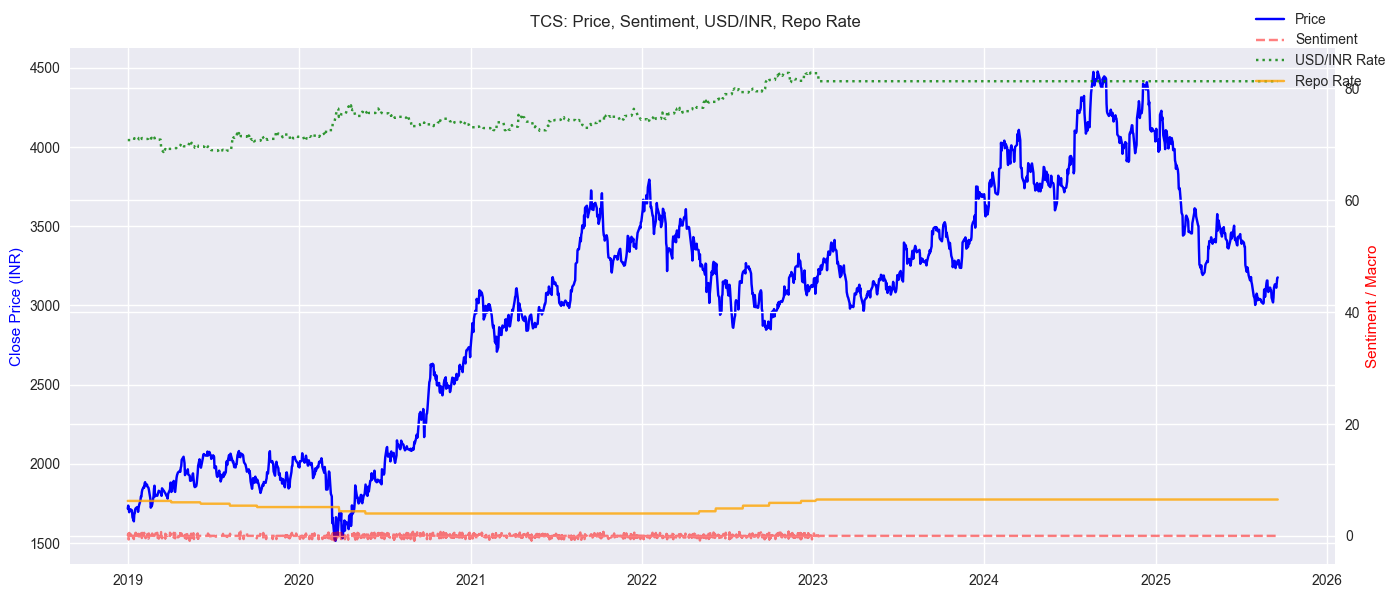

In [7]:
ticker = "TCS" # Change as needed
sub = df[df['ticker'] == ticker].sort_values('date')

fig, ax1 = plt.subplots()
ax1.plot(sub['date'], sub['close_price'], label='Price', color='b')
ax1.set_ylabel("Close Price (INR)", color='b')
ax2 = ax1.twinx()
ax2.plot(sub['date'], sub['sentiment_score'], 'r--', label='Sentiment', alpha=0.5)
ax2.plot(sub['date'], sub['usd_inr_rate'], 'g:', label='USD/INR Rate', alpha=0.8)
ax2.plot(sub['date'], sub['interest_rate'], 'orange', label='Repo Rate', alpha=0.8)
ax2.set_ylabel("Sentiment / Macro", color='r')
fig.suptitle(f"{ticker}: Price, Sentiment, USD/INR, Repo Rate")
fig.tight_layout()
fig.legend(loc="upper right")
plt.show()


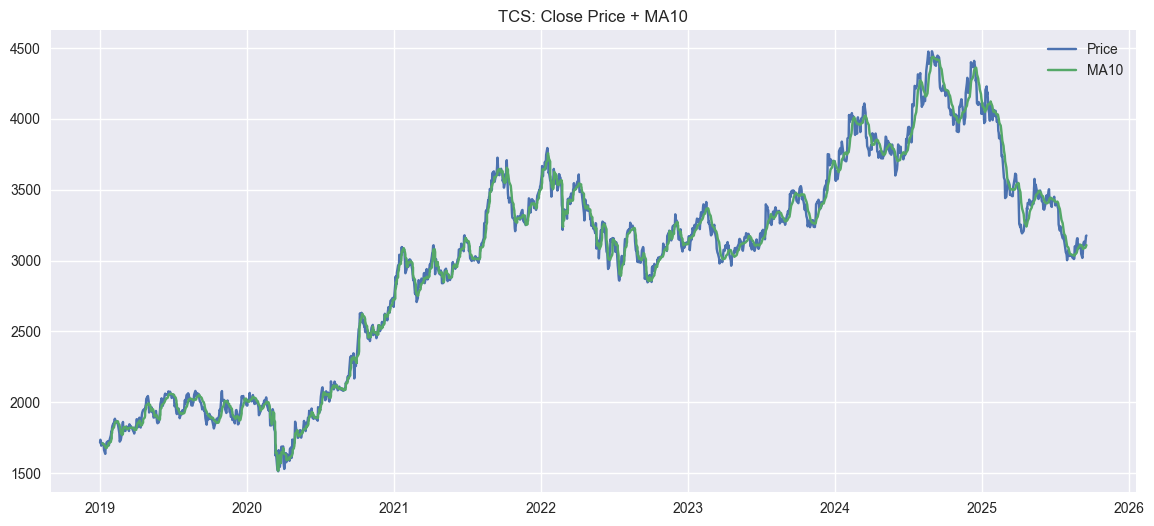

In [8]:
window = 10
sub['MA10'] = sub['close_price'].rolling(window).mean()
sub['RSI'] = sub['close_price'].pct_change().rolling(window).apply(lambda x: (np.where(x > 0, x, 0).sum() / np.abs(x).sum()) * 100 if np.abs(x).sum() > 0 else np.nan)

plt.plot(sub['date'], sub['close_price'], label='Price')
plt.plot(sub['date'], sub['MA10'], label='MA10')
plt.legend(); plt.title(f'{ticker}: Close Price + MA10')
plt.show()


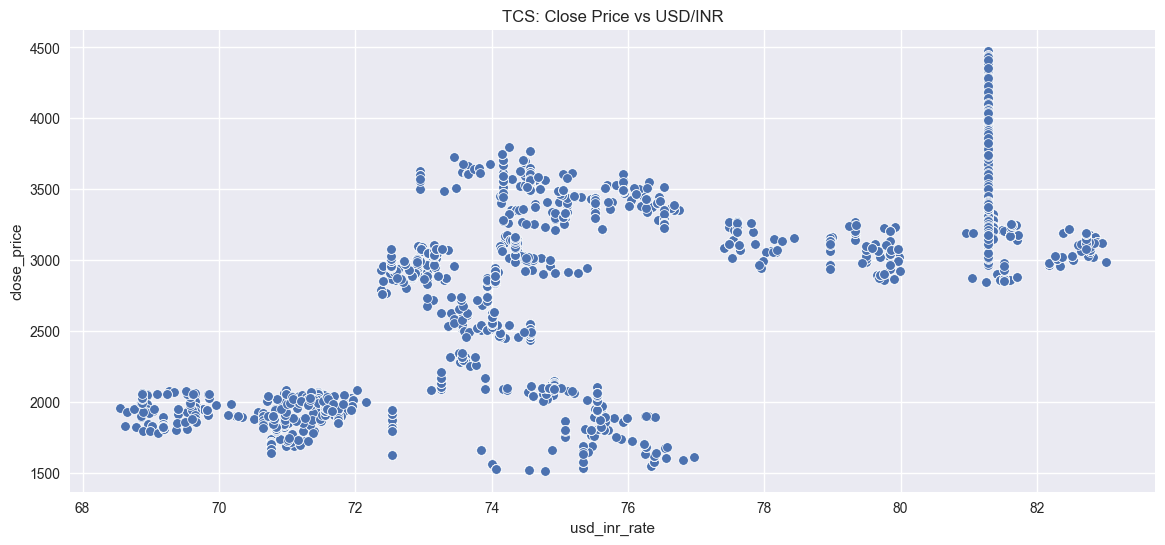

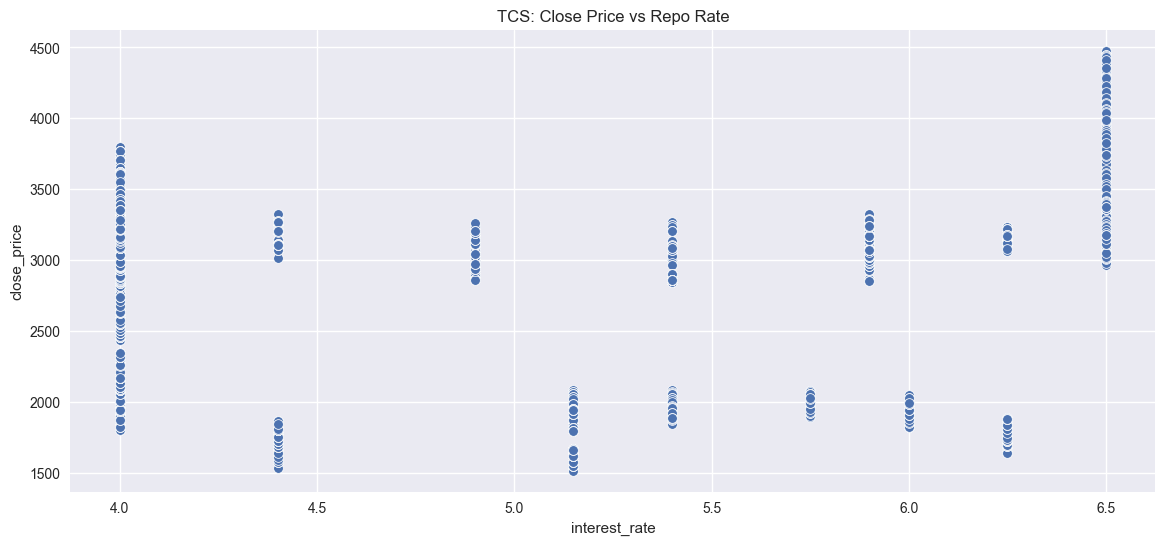

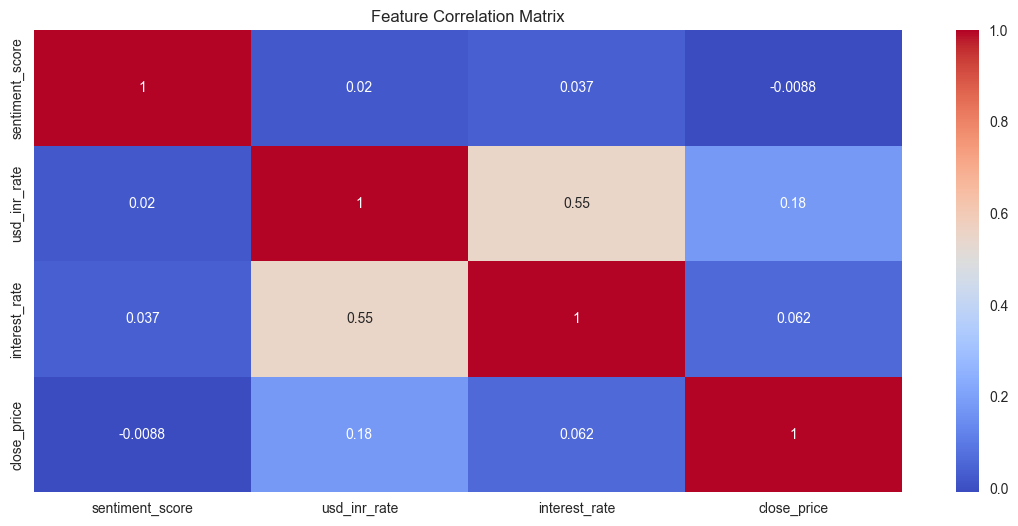

In [9]:
sns.scatterplot(data=sub, x='usd_inr_rate', y='close_price')
plt.title(f'{ticker}: Close Price vs USD/INR')
plt.show()

sns.scatterplot(data=sub, x='interest_rate', y='close_price')
plt.title(f'{ticker}: Close Price vs Repo Rate')
plt.show()

sns.heatmap(df[['sentiment_score', 'usd_inr_rate', 'interest_rate', 'close_price']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

features = ['close_price', 'sentiment_score', 'usd_inr_rate', 'interest_rate','unemployment_rate']
X = df[features]
y = df['return_direction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


Accuracy: 0.6650400156158501
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      3611
           1       0.44      0.54      0.49      1512

    accuracy                           0.67      5123
   macro avg       0.62      0.63      0.62      5123
weighted avg       0.69      0.67      0.67      5123



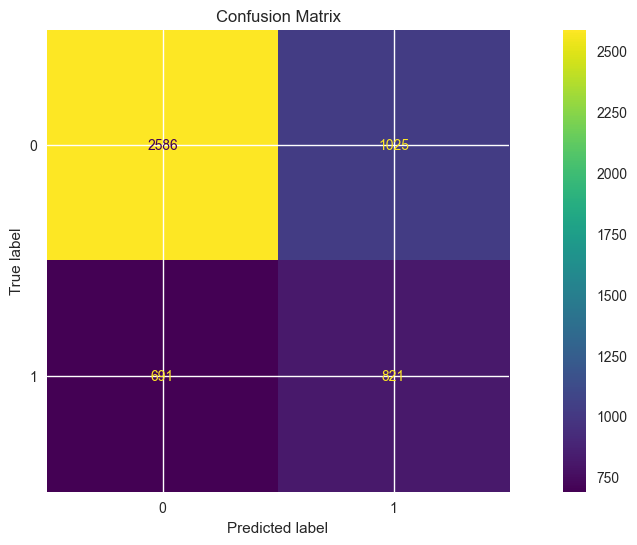

In [11]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred); plt.title("Confusion Matrix"); plt.show()


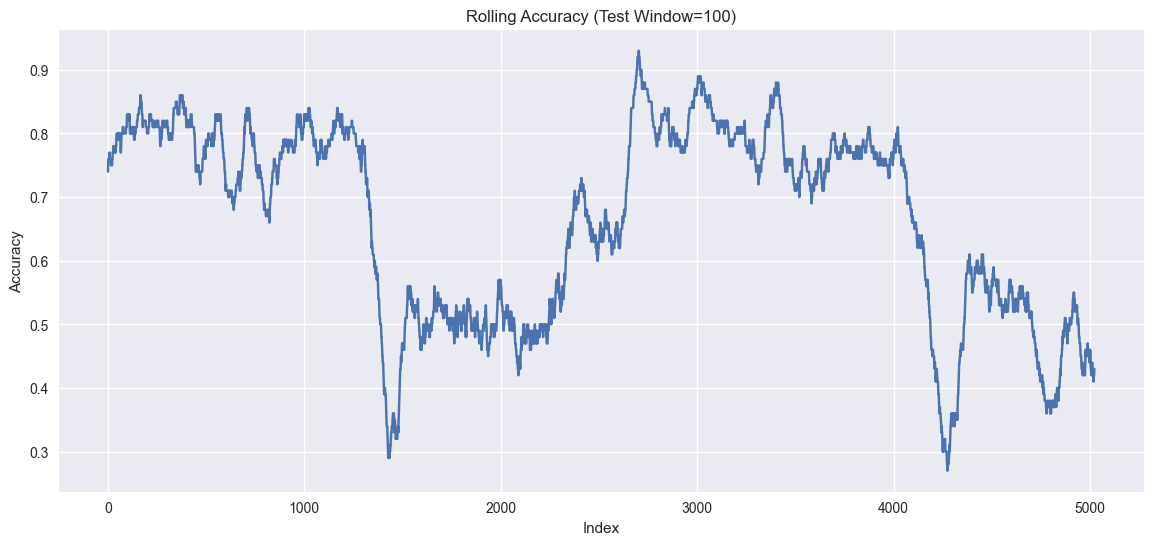

In [12]:
window_size = 100
rolling_acc = pd.Series([accuracy_score(y_test.iloc[i:i+window_size], y_pred[i:i+window_size]) for i in range(len(y_test)-window_size)])
plt.plot(rolling_acc)
plt.title('Rolling Accuracy (Test Window=100)')
plt.xlabel('Index'); plt.ylabel('Accuracy')
plt.show()


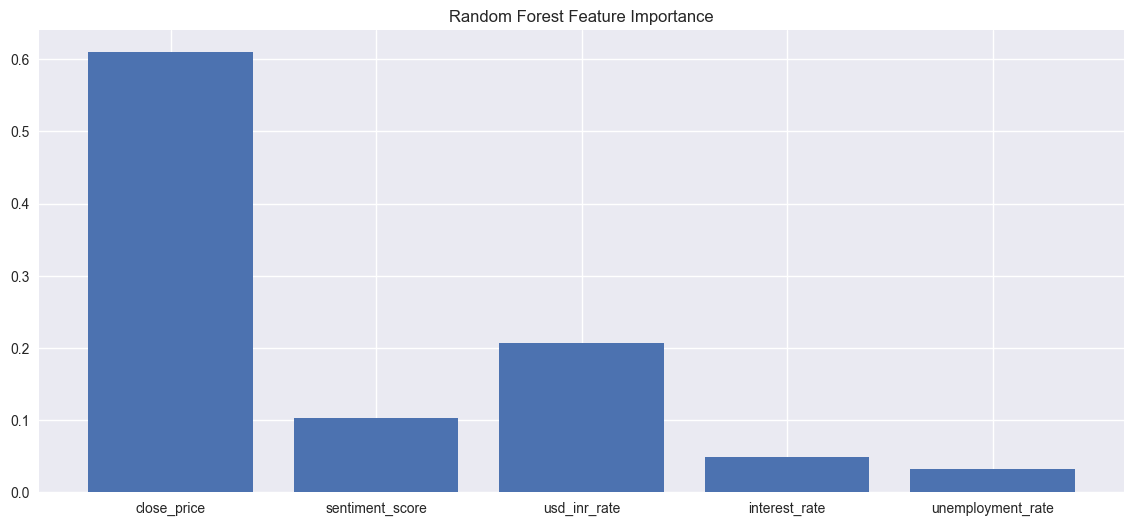

In [13]:
importances = rf.feature_importances_
plt.bar(features, importances)
plt.title('Random Forest Feature Importance')
plt.show()


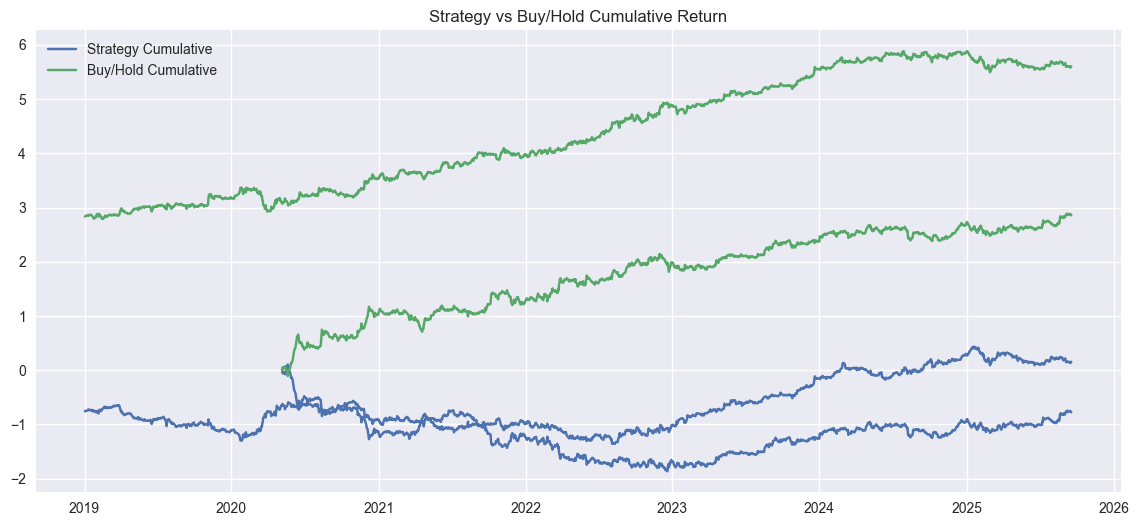

In [14]:
test_df = df.iloc[y_test.index].copy()
test_df['pred_signal'] = y_pred
test_df['strategy_return'] = test_df['return_1'] * test_df['pred_signal'].map({1: 1, 0: -1})
plt.plot(test_df['date'], test_df['strategy_return'].cumsum(), label='Strategy Cumulative')
plt.plot(test_df['date'], test_df['return_1'].cumsum(), label='Buy/Hold Cumulative')
plt.legend(); plt.title('Strategy vs Buy/Hold Cumulative Return')
plt.show()


In [15]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10, None]}
search = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=3, scoring='accuracy', verbose=2)
search.fit(X_train, y_train)
print(search.best_params_)
print("Best CV accuracy:", search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=3, n_estimators=200; total time=   1.4s
[CV] END ......................max_depth=3, n_estimators=200; total time=   1.4s
[CV] END ......................max_depth=3, n_estimators=200; total time=   1.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=5, n_e

## Conclusion & Next Steps

- Model predicts price return direction using sentiment & macro; accuracy and feature ranking shown.
- Simulated backtest demonstrates practical strategy vs. buy-and-hold.
- Further improvements: Add technical indicators, try time-series models, refine ticker-level sentiment, optimize hyperparameters.


C:\Users\harsh\AppData\Local\Temp\ipykernel_1764\2394171901.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  wb_df = wb.download(indicator=indicator, country=country, start=start, end=end)


Unemployment data downloaded successfully!
         date  unemployment_rate
13 2010-01-01              7.652
12 2011-01-01              7.616
11 2012-01-01              7.666
10 2013-01-01              7.711
9  2014-01-01              7.674
Loaded existing macro data successfully!
Saved macro data with unemployment to macro_all_clean.csv
Shape: (1474, 4)

Preview:
        date  usd_inr_rate  interest_rate  unemployment_rate
0 2019-01-01         70.76           6.25               6.51
1 2019-01-02         70.76           6.25               6.51
2 2019-01-03         70.76           6.25               6.51
3 2019-01-04         70.76           6.25               6.51
4 2019-01-05         70.76           6.25               6.51
5 2019-01-06         70.76           6.25               6.51
6 2019-01-07         70.76           6.25               6.51
7 2019-01-08         70.76           6.25               6.51
8 2019-01-09         70.76           6.25               6.51
9 2019-01-10         70

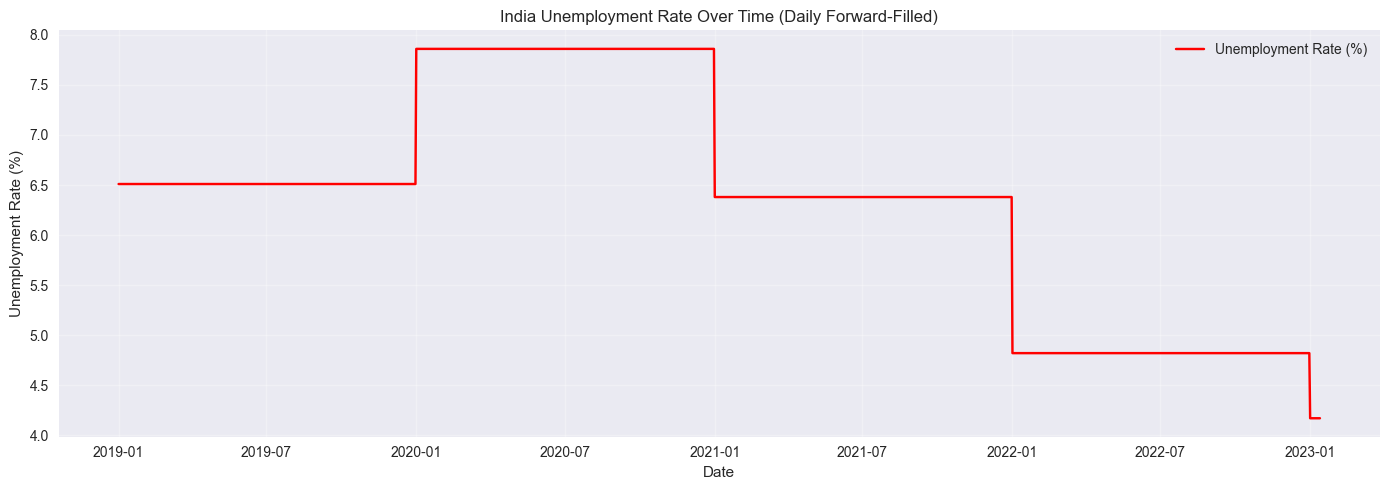


Missing values check:
usd_inr_rate         0
interest_rate        0
unemployment_rate    0
dtype: int64


In [16]:
# Add Unemployment Rate to Macro Features
import pandas as pd
from pandas_datareader import wb
import matplotlib.pyplot as plt

# Step 1: Download unemployment data from World Bank
print("Downloading unemployment data...")
indicator = 'SL.UEM.TOTL.ZS'  # Unemployment, total (% of total labor force)
country = 'IN'  # India
start, end = 2010, 2023

try:
    wb_df = wb.download(indicator=indicator, country=country, start=start, end=end)
    wb_df = wb_df.reset_index().rename(columns={'year':'Year', indicator:'unemployment_rate'})
    wb_df = wb_df.sort_values('Year')
    wb_df['date'] = pd.to_datetime(wb_df['Year'].astype(str) + '-01-01')
    wb_df = wb_df[['date','unemployment_rate']].dropna()
    print("Unemployment data downloaded successfully!")
    print(wb_df.head())
except Exception as e:
    print(f"Error downloading from World Bank: {e}")
    # Fallback: Create manual data for 2019-2023
    manual_data = {
        '2019-01-01': 2.55,
        '2020-01-01': 4.84,
        '2021-01-01': 4.66,
        '2022-01-01': 4.10,
        '2023-01-01': 3.25
    }
    wb_df = pd.DataFrame(list(manual_data.items()), columns=['date', 'unemployment_rate'])
    wb_df['date'] = pd.to_datetime(wb_df['date'])
    print("Using manual unemployment data:")
    print(wb_df)

# Step 2: Expand to daily series
daily = pd.DataFrame({'date': pd.date_range('2019-01-01','2023-01-13', freq='D')})
unemp_daily = daily.merge(wb_df, on='date', how='left').sort_values('date')
unemp_daily['unemployment_rate'] = unemp_daily['unemployment_rate'].ffill().bfill()

# Step 3: Load existing macro data
try:
    fx = pd.read_csv('../data/usdinr_clean.csv', parse_dates=['date'])
    repo = pd.read_csv('../data/repo_daily_clean.csv', parse_dates=['date'])
    print("Loaded existing macro data successfully!")
except FileNotFoundError as e:
    print(f"File not found: {e}")
    print("Please make sure your macro CSV files exist in the data folder")

# Step 4: Merge all macro data
macro = fx.merge(repo, on='date', how='outer').merge(unemp_daily, on='date', how='outer').sort_values('date')

# Fill missing values
macro['usd_inr_rate'] = macro['usd_inr_rate'].ffill().bfill()
macro['interest_rate'] = macro['interest_rate'].ffill().bfill()
macro['unemployment_rate'] = macro['unemployment_rate'].ffill().bfill()

# Step 5: Save updated macro data
macro.to_csv('../data/macro_all_clean.csv', index=False)
print(f"Saved macro data with unemployment to macro_all_clean.csv")
print(f"Shape: {macro.shape}")
print("\nPreview:")
print(macro.head(10))
print("\nTail:")
print(macro.tail(10))

# Step 6: Visualize unemployment rate
plt.figure(figsize=(14,5))
plt.plot(macro['date'], macro['unemployment_rate'], label='Unemployment Rate (%)', color='red')
plt.title('India Unemployment Rate Over Time (Daily Forward-Filled)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Check for missing values
print("\nMissing values check:")
print(macro[['usd_inr_rate', 'interest_rate', 'unemployment_rate']].isna().sum())


In [17]:
df = pd.read_csv('../data/features.csv', parse_dates=['date'])
print("Features with unemployment:")
print(df[['date','ticker','unemployment_rate']].head())
print(f"Non-null unemployment: {df['unemployment_rate'].notna().sum()}")


Features with unemployment:
        date ticker  unemployment_rate
0 2019-01-01    TCS               6.51
1 2019-01-02    TCS               6.51
2 2019-01-03    TCS               6.51
3 2019-01-03    TCS               6.51
4 2019-01-03    TCS               6.51
Non-null unemployment: 17076


In [18]:
# Create Market Events Calendar
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define major market events for India (2019-2023)
events_data = {
    # Union Budget dates
    '2019-02-01': {'event': 'Union Budget 2019', 'type': 'budget', 'impact': 'high'},
    '2020-02-01': {'event': 'Union Budget 2020', 'type': 'budget', 'impact': 'high'},
    '2021-02-01': {'event': 'Union Budget 2021', 'type': 'budget', 'impact': 'high'},
    '2022-02-01': {'event': 'Union Budget 2022', 'type': 'budget', 'impact': 'high'},
    '2023-02-01': {'event': 'Union Budget 2023', 'type': 'budget', 'impact': 'high'},
    
    # RBI Monetary Policy Committee (MPC) meetings - major ones
    '2019-02-07': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2019-04-04': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2019-06-06': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2019-08-07': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2019-10-04': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2019-12-05': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    
    '2020-02-06': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2020-03-27': {'event': 'RBI Emergency Cut', 'type': 'monetary_policy', 'impact': 'high'},
    '2020-04-17': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2020-05-22': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2020-08-06': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2020-10-09': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2020-12-04': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    
    '2021-02-05': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2021-04-07': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2021-06-04': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2021-08-06': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2021-10-08': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2021-12-08': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    
    '2022-02-10': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2022-04-08': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2022-06-08': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2022-08-05': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2022-09-30': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    '2022-12-07': {'event': 'RBI MPC Meeting', 'type': 'monetary_policy', 'impact': 'medium'},
    
    # Major policy announcements
    '2019-03-20': {'event': 'Lok Sabha Election Results', 'type': 'election', 'impact': 'high'},
    '2020-03-24': {'event': 'COVID Lockdown Announcement', 'type': 'policy', 'impact': 'high'},
    '2021-04-14': {'event': 'COVID Second Wave Peak', 'type': 'health', 'impact': 'medium'},
    '2022-02-24': {'event': 'Russia-Ukraine War Impact', 'type': 'geopolitical', 'impact': 'medium'},
    
    # Economic data releases (quarterly GDP)
    '2019-05-31': {'event': 'Q4 FY19 GDP Release', 'type': 'economic_data', 'impact': 'medium'},
    '2019-08-30': {'event': 'Q1 FY20 GDP Release', 'type': 'economic_data', 'impact': 'medium'},
    '2019-11-29': {'event': 'Q2 FY20 GDP Release', 'type': 'economic_data', 'impact': 'medium'},
    '2020-02-28': {'event': 'Q3 FY20 GDP Release', 'type': 'economic_data', 'impact': 'medium'},
}

# Convert to DataFrame
events_df = pd.DataFrame([
    {'date': pd.to_datetime(date), 'event_name': info['event'], 
     'event_type': info['type'], 'impact_level': info['impact']}
    for date, info in events_data.items()
])

# Sort by date
events_df = events_df.sort_values('date').reset_index(drop=True)

print("Market Events Calendar:")
print(events_df.head(10))
print(f"\nTotal events: {len(events_df)}")
print(f"Date range: {events_df['date'].min()} to {events_df['date'].max()}")

# Save events
events_df.to_csv('../data/market_events.csv', index=False)
print("✅ Events saved to market_events.csv")


Market Events Calendar:
        date                  event_name       event_type impact_level
0 2019-02-01           Union Budget 2019           budget         high
1 2019-02-07             RBI MPC Meeting  monetary_policy       medium
2 2019-03-20  Lok Sabha Election Results         election         high
3 2019-04-04             RBI MPC Meeting  monetary_policy       medium
4 2019-05-31         Q4 FY19 GDP Release    economic_data       medium
5 2019-06-06             RBI MPC Meeting  monetary_policy       medium
6 2019-08-07             RBI MPC Meeting  monetary_policy       medium
7 2019-08-30         Q1 FY20 GDP Release    economic_data       medium
8 2019-10-04             RBI MPC Meeting  monetary_policy       medium
9 2019-11-29         Q2 FY20 GDP Release    economic_data       medium

Total events: 38
Date range: 2019-02-01 00:00:00 to 2023-02-01 00:00:00
✅ Events saved to market_events.csv


In [19]:
# Create Event Features for Daily Data
def create_event_features(base_date_range, events_df, window_days=7):
    """
    Create event-based features:
    - days_to_next_event: days until next major event
    - days_since_last_event: days since last major event  
    - is_event_window: 1 if within ±window_days of any event
    - event_impact_score: weighted impact (high=3, medium=2, low=1)
    """
    
    daily_df = pd.DataFrame({'date': base_date_range})
    daily_df = daily_df.sort_values('date')
    
    # Initialize feature columns
    daily_df['days_to_next_event'] = np.nan
    daily_df['days_since_last_event'] = np.nan
    daily_df['is_event_window'] = 0
    daily_df['event_impact_score'] = 0
    daily_df['upcoming_event_type'] = 'none'
    daily_df['recent_event_type'] = 'none'
    
    impact_weights = {'high': 3, 'medium': 2, 'low': 1}
    
    for idx, row in daily_df.iterrows():
        current_date = row['date']
        
        # Find next event
        future_events = events_df[events_df['date'] > current_date]
        if len(future_events) > 0:
            next_event = future_events.iloc[0]
            days_to_next = (next_event['date'] - current_date).days
            daily_df.at[idx, 'days_to_next_event'] = days_to_next
            daily_df.at[idx, 'upcoming_event_type'] = next_event['event_type']
        
        # Find last event
        past_events = events_df[events_df['date'] <= current_date]
        if len(past_events) > 0:
            last_event = past_events.iloc[-1]
            days_since_last = (current_date - last_event['date']).days
            daily_df.at[idx, 'days_since_last_event'] = days_since_last
            daily_df.at[idx, 'recent_event_type'] = last_event['event_type']
        
        # Check if in event window (±7 days around any event)
        for _, event in events_df.iterrows():
            days_diff = abs((current_date - event['date']).days)
            if days_diff <= window_days:
                daily_df.at[idx, 'is_event_window'] = 1
                # Add impact score (multiple events can overlap)
                daily_df.at[idx, 'event_impact_score'] += impact_weights[event['impact_level']]
                break
    
    # Fill NaN values
    daily_df['days_to_next_event'] = daily_df['days_to_next_event'].fillna(365)  # Far future
    daily_df['days_since_last_event'] = daily_df['days_since_last_event'].fillna(365)  # Far past
    
    return daily_df

# Create event features
date_range = pd.date_range('2019-01-01', '2023-01-13', freq='D')
events_features = create_event_features(date_range, events_df, window_days=7)

print("Event Features Preview:")
print(events_features.head(10))

# Show event windows
event_windows = events_features[events_features['is_event_window'] == 1]
print(f"\nEvent windows (±7 days): {len(event_windows)} days")
print("Sample event windows:")
print(event_windows[['date', 'is_event_window', 'event_impact_score', 'upcoming_event_type']].head())

# Save event features
events_features.to_csv('../data/event_features.csv', index=False)
print("✅ Event features saved to event_features.csv")


Event Features Preview:
        date  days_to_next_event  days_since_last_event  is_event_window  \
0 2019-01-01                31.0                  365.0                0   
1 2019-01-02                30.0                  365.0                0   
2 2019-01-03                29.0                  365.0                0   
3 2019-01-04                28.0                  365.0                0   
4 2019-01-05                27.0                  365.0                0   
5 2019-01-06                26.0                  365.0                0   
6 2019-01-07                25.0                  365.0                0   
7 2019-01-08                24.0                  365.0                0   
8 2019-01-09                23.0                  365.0                0   
9 2019-01-10                22.0                  365.0                0   

   event_impact_score upcoming_event_type recent_event_type  
0                   0              budget              none  
1              

In [20]:
# Merge Events with Macro Data
macro = pd.read_csv('../data/macro_all_clean.csv', parse_dates=['date'])
events_features = pd.read_csv('../data/event_features.csv', parse_dates=['date'])

# Merge
macro_with_events = macro.merge(events_features, on='date', how='left')

# Fill any missing event features with defaults
event_cols = ['days_to_next_event', 'days_since_last_event', 'is_event_window', 'event_impact_score']
for col in event_cols:
    if col in ['days_to_next_event', 'days_since_last_event']:
        macro_with_events[col] = macro_with_events[col].fillna(365)
    else:
        macro_with_events[col] = macro_with_events[col].fillna(0)

macro_with_events['upcoming_event_type'] = macro_with_events['upcoming_event_type'].fillna('none')
macro_with_events['recent_event_type'] = macro_with_events['recent_event_type'].fillna('none')

print("Macro + Events Data Preview:")
print(macro_with_events.head())
print(f"Shape: {macro_with_events.shape}")

# Save complete macro data with events
macro_with_events.to_csv('../data/macro_complete.csv', index=False)
print("✅ Complete macro data with events saved!")

# Preview during Budget week
budget_period = macro_with_events[
    (macro_with_events['date'] >= '2020-01-28') & 
    (macro_with_events['date'] <= '2020-02-05')
]
print("\nBudget 2020 period (Jan 28 - Feb 5):")
print(budget_period[['date', 'is_event_window', 'event_impact_score', 'days_to_next_event']].to_string(index=False))


Macro + Events Data Preview:
        date  usd_inr_rate  interest_rate  unemployment_rate  \
0 2019-01-01         70.76           6.25               6.51   
1 2019-01-02         70.76           6.25               6.51   
2 2019-01-03         70.76           6.25               6.51   
3 2019-01-04         70.76           6.25               6.51   
4 2019-01-05         70.76           6.25               6.51   

   days_to_next_event  days_since_last_event  is_event_window  \
0                31.0                  365.0                0   
1                30.0                  365.0                0   
2                29.0                  365.0                0   
3                28.0                  365.0                0   
4                27.0                  365.0                0   

   event_impact_score upcoming_event_type recent_event_type  
0                   0              budget              none  
1                   0              budget              none  
2        

In [21]:
# Notebook cell: Merge event features into final features dataset
import pandas as pd

# Load existing features (prices+sentiment+macro)
df = pd.read_csv('../data/features.csv', parse_dates=['date'])

# Load complete macro with events
macro_events = pd.read_csv('../data/macro_complete.csv', parse_dates=['date'])

# Merge on date
df_full = df.merge(
    macro_events[['date',
                  'days_to_next_event',
                  'days_since_last_event',
                  'is_event_window',
                  'event_impact_score']],
    on='date',
    how='left'
)

# Fill any NaNs if needed
df_full['is_event_window'] = df_full['is_event_window'].fillna(0)
df_full['event_impact_score'] = df_full['event_impact_score'].fillna(0)
df_full['days_to_next_event'] = df_full['days_to_next_event'].fillna(365)
df_full['days_since_last_event'] = df_full['days_since_last_event'].fillna(365)

# Save updated features for modeling
df_full.to_csv('../data/features_with_events.csv', index=False)
print("Saved features_with_events.csv with shape:", df_full.shape)
print(df_full.head())


Saved features_with_events.csv with shape: (17076, 13)
        date ticker  close_price  sentiment_score  usd_inr_rate  \
0 2019-01-01    TCS    1717.5715           0.0000         70.76   
1 2019-01-02    TCS    1736.0759           0.3818         70.76   
2 2019-01-03    TCS    1714.9988          -0.6486         70.76   
3 2019-01-03    TCS    1714.9988           0.0000         70.76   
4 2019-01-03    TCS    1714.9988          -0.3400         70.76   

   interest_rate  unemployment_rate  return_1  return_direction  \
0           6.25               6.51       NaN                 1   
1           6.25               6.51  0.010774                 0   
2           6.25               6.51 -0.012141                 0   
3           6.25               6.51  0.000000                 0   
4           6.25               6.51  0.000000                 0   

   days_to_next_event  days_since_last_event  is_event_window  \
0                31.0                  365.0              0.0   
1        

In [22]:
# Old features list
# features = ['close_price','sentiment_score','usd_inr_rate','interest_rate','unemployment_rate']

# New features list with event features
features = [
    'close_price',
    'sentiment_score',
    'usd_inr_rate',
    'interest_rate',
    'unemployment_rate',
    'days_to_next_event',
    'days_since_last_event',
    'is_event_window',
    'event_impact_score'
]

# Reload updated dataset
df_model = pd.read_csv('../data/features_with_events.csv', parse_dates=['date'])
X = df_model[features]
y = df_model['return_direction']


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split chronologically
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

# Train
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predict & evaluate
y_pred = rf.predict(X_test)
print("Accuracy with events:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy with events: 0.704274838961546
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      3611
           1       0.50      0.44      0.47      1512

    accuracy                           0.70      5123
   macro avg       0.64      0.63      0.63      5123
weighted avg       0.69      0.70      0.70      5123



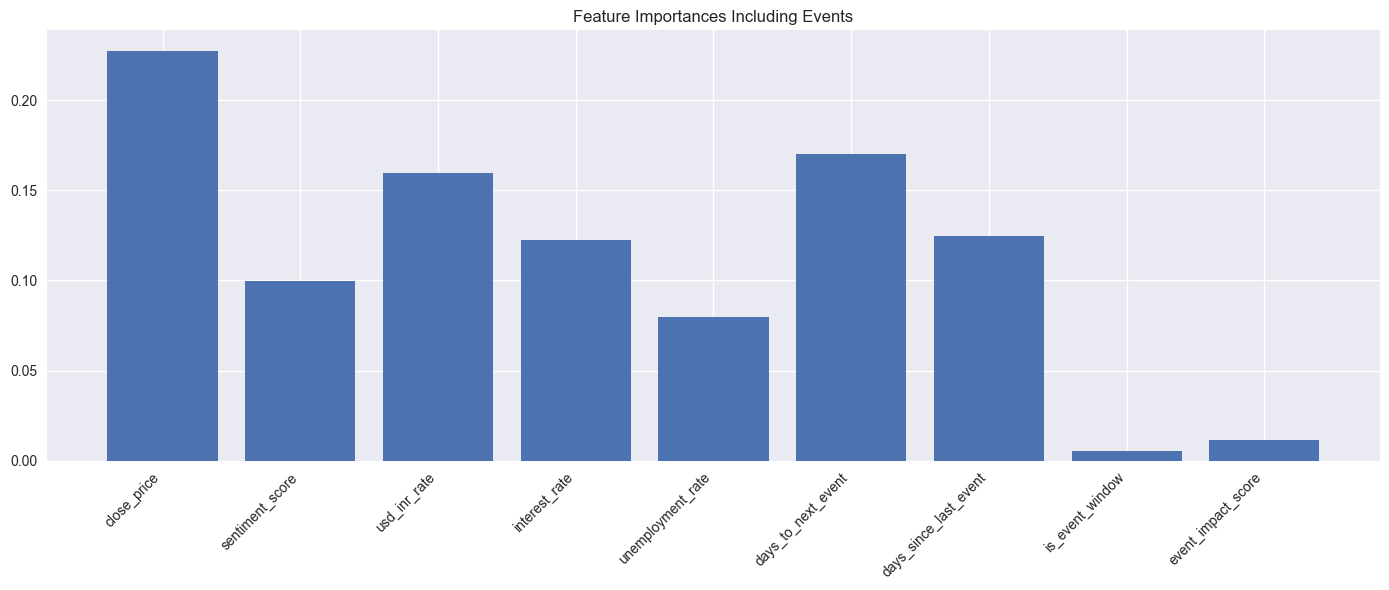

In [24]:
import matplotlib.pyplot as plt
importances = rf.feature_importances_
plt.bar(features, importances)
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances Including Events')
plt.tight_layout()
plt.show()
